In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [43]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": True, "pressure": 0.0013933}

In [52]:
project.detect_schema()

ProjectSchema(<len=19>)

In [53]:
job.doc.ref_length

0.3438

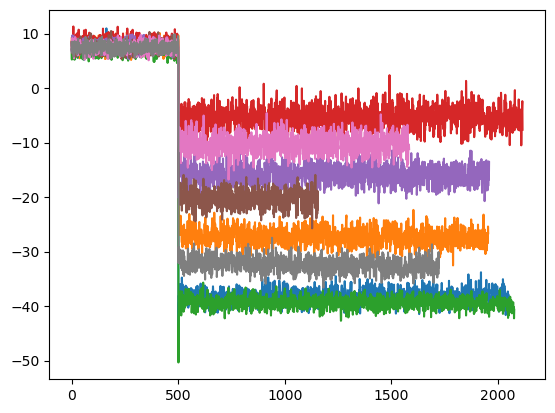

In [55]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pressure = data["mdcomputeThermodynamicQuantitiespressure"]
    #plt.plot(vol[3600:])
    #plt.plot(temp[3950:])
    plt.plot(pressure[3500:])

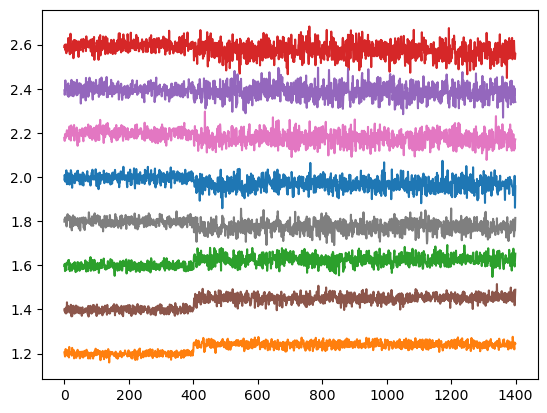

In [46]:
job_filter = {"remove_hydrogens": True, "remove_charges": True, "pressure": 0.0013933}
for job in project.find_jobs(filter=job_filter):
    if job.sp.kT*10 % 2 != 0:
        continue
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    plt.plot(temp[3600:5000])

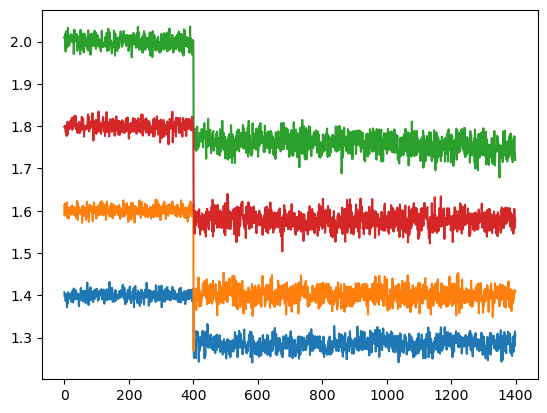

In [51]:
job_filter = {"remove_hydrogens": False, "remove_charges": False, "pressure": 0.0013933}
for job in project.find_jobs(filter=job_filter):
    if job.sp.kT*10 % 2 != 0:
        continue
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    plt.plot(temp[3600:5000])

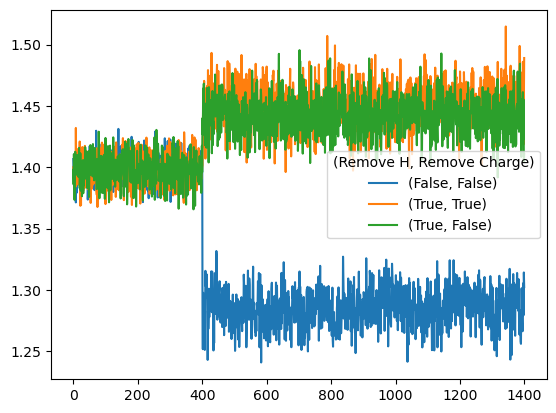

In [50]:
job_filter = {"kT": 1.4, "pressure": 0.0013933}
for job in project.find_jobs(filter=job_filter):
    if job.sp.kT*10 % 2 != 0:
        continue
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    temp = data["mdcomputeThermodynamicQuantitieskinetic_temperature"]
    label = (job.sp.remove_hydrogens, job.sp.remove_charges)
    plt.plot(temp[3600:5000], label=label)

plt.legend(title="(Remove H, Remove Charge)")

In [42]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    sample_idx = len(vol)//2
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    print(vol_eq, pe_eq)
    print()

In [25]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    sample_idx = len(vol)//2
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
        vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100
    )
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    #np.savetxt(job.fn("vol_sample_indices.txt"), uncorr_indices + sample_idx)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

1.3 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/a0d40755f056a2c17be41df450bebfc3
1.4 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/a6a1007b0cd28a075a14a1839e27ef6d
1.5 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/274bfa4eadd5c6d8b0897a8312fc7593
1.6 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/9f203791d00ce7d0b5a3d2f257b192f3
1.7 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/71a6b431433f816555f079bf3db2fd70
1.8 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/97620a3383aa51c9a86a97dd518d313f
1.9 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/b246ae831cce003da6e1f7e7789aca35
2.0 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/01a9b80197524faa41297f3dbdd8d39e


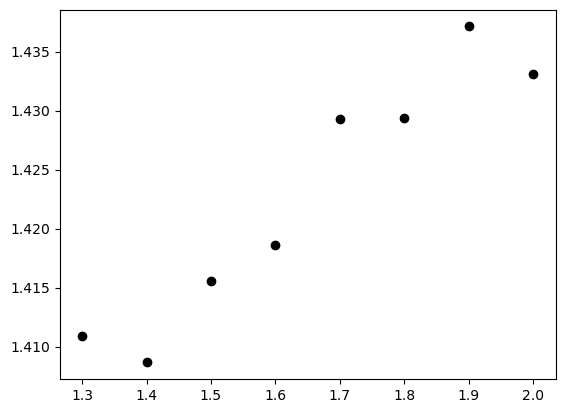

In [40]:
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    if kT < 1.1 or kT> 2.0: continue
    job = list(job)[0]
    print(kT, job.path)
    #print(kT, job.path)
    plt.plot(kT, job.doc.avg_density, "ko")
    #plt.vlines(x=1.67, ymin=0.68, ymax=0.72, ls="--", color="red")

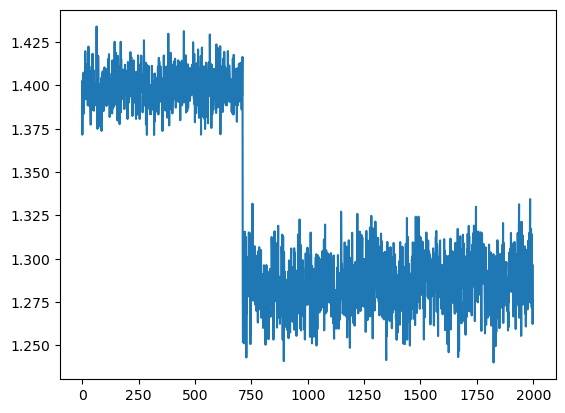

In [42]:
plt.plot(data["mdcomputeThermodynamicQuantitieskinetic_temperature"][-2000:])